In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import pickle
import copy
from shapely import geometry

# Prepare data for PCA

In [2]:
ds_era_anomalies = xr.open_dataset('/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/anomalies/z500_anomalies_v1959_2010_detrended.nc')


In [3]:
def get_cold_indx(ds, mo_init=9, mo_end=2):
    """
    Extract indices for cold season.
    Grabbing Sept thru February init, for Oct thru March predictions.
    """
    dt_array = pd.to_datetime(ds['time'])
    return xr.where((dt_array.month>=mo_init) | (dt_array.month<=mo_end), True, False)

In [4]:
cold_indx = get_cold_indx(ds_era_anomalies,10,3)
ds_era_anomalies = ds_era_anomalies.isel(time=cold_indx)


In [5]:
# region for clustering
lat0=10; lat1=70; lon0=210; lon1=320
ds_era_anomalies = ds_era_anomalies.where((ds_era_anomalies.lat>=lat0)&(ds_era_anomalies.lat<=lat1)&\
                   (ds_era_anomalies.lon>=lon0)&(ds_era_anomalies.lon<=lon1),drop=True)

In [6]:
ds_era_anomalies = ds_era_anomalies.rolling(
        time=7, min_periods=1, center=True).mean(skipna=True)

In [7]:
ds_era5_train = ds_era_anomalies.stack(flat=('lat','lon')).transpose('time','flat').z500_anomalies
data_era5_train = ds_era5_train.data

# PCA + kmeans

In [9]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(data_era5_train)

# transform era5 data with pca
data_era5_train = pca_obj.transform(data_era5_train)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

Variance explained: [27.1446844  17.14888695 12.43398257  9.22408452  8.25116313  6.27709378
  3.80151864  2.54841096  2.30800068  1.89999708  1.46452285  1.08412332]
Cumulative sum of variance explained for EOF1 and EOF2: [27.1446844  44.29357135 56.72755392 65.95163844 74.20280156 80.47989535
 84.28141399 86.82982494 89.13782562 91.03782271 92.50234556 93.58646888]


In [10]:
# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(data_era5_train)

print(f'inertia: {k_means.inertia_}')

inertia: 118889.90179542976


In [11]:
import joblib

filename = r'/glade/work/jhayron/Weather_Regimes/models/PCA_ERA5_v4.mdl'
joblib.dump(pca_obj,filename)

filename = r'/glade/work/jhayron/Weather_Regimes/models/KMeans_ERA5_v4.mdl'
joblib.dump(k_means,filename)


['/glade/work/jhayron/Weather_Regimes/models/KMeans_ERA5_v4.mdl']

In [12]:
filename = r'/glade/work/jhayron/Weather_Regimes/models/PCA_ERA5_v4.pkl'
pickle.dump(pca_obj, open(filename, 'wb'))

filename = r'/glade/work/jhayron/Weather_Regimes/models/KMeans_ERA5_v4.pkl'
pickle.dump(k_means, open(filename, 'wb'))

In [13]:
ds_era5_afterPCA = copy.deepcopy(ds_era5_train)
ds_era5_afterPCA.data = pca_obj.inverse_transform(data_era5_train)

In [14]:
ds_era5_afterPCA = ds_era5_afterPCA.unstack('flat')

## Load models

In [15]:
import joblib
pca_obj = joblib.load(r'/glade/work/jhayron/Weather_Regimes/models/PCA_ERA5_v4.mdl')
k_means = joblib.load(r'/glade/work/jhayron/Weather_Regimes/models/KMeans_ERA5_v4.pkl')
# data_era5_train = pca_obj.transform(data_era5_train)

# Check results

In [16]:
weather_patterns = k_means.predict(data_era5_train)

where0 = np.where(weather_patterns==0)
where1 = np.where(weather_patterns==1)
where2 = np.where(weather_patterns==2)
where3 = np.where(weather_patterns==3)

In [17]:
len(weather_patterns)

11482

In [18]:
pd.DataFrame(weather_patterns,index=pd.to_datetime(ds_era5_train.time)).\
    to_csv('/glade/work/jhayron/Weather_Regimes/WR_Series_v3.csv')

In [19]:
print('Pattern #0:')
print(np.round(100*len(where0[0])/len(weather_patterns),2))

print('Pattern #1:')
print(np.round(100*len(where1[0])/len(weather_patterns),2))

print('Pattern #2:')
print(np.round(100*len(where2[0])/len(weather_patterns),2))

print('Pattern #3:')
print(np.round(100*len(where3[0])/len(weather_patterns),2))

Pattern #0:
20.83
Pattern #1:
21.01
Pattern #2:
25.88
Pattern #3:
32.29


In [20]:
p0 = np.round(len(where0[0])/len(weather_patterns),2)
p1 = np.round(len(where1[0])/len(weather_patterns),2)
p2 = np.round(len(where2[0])/len(weather_patterns),2)
p3 = np.round(len(where3[0])/len(weather_patterns),2)

In [21]:
ds_era5_afterPCA = ds_era5_afterPCA / 9.82

In [22]:
ds_era_anomalies.z500_anomalies.shape

(11482, 61, 111)

In [23]:
mean_wr_0 = ds_era5_afterPCA[where0].mean(axis=0)
mean_wr_1 = ds_era5_afterPCA[where1].mean(axis=0)
mean_wr_2 = ds_era5_afterPCA[where2].mean(axis=0)
mean_wr_3 = ds_era5_afterPCA[where3].mean(axis=0)

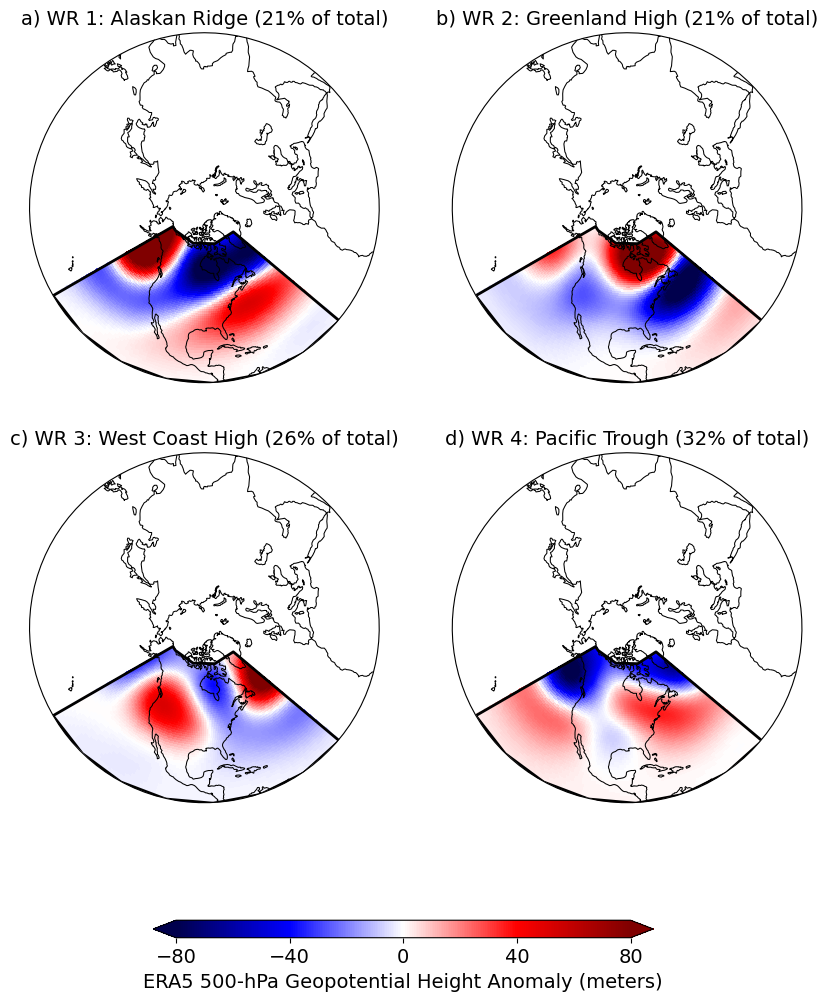

In [25]:
lons, lats = np.meshgrid(ds_era5_afterPCA.lon, ds_era5_afterPCA.lat)

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90+360)),
    figsize=(10, 10))

# ---

axs[0][0].pcolormesh(lons, lats, mean_wr_0,
                     transform=ccrs.PlateCarree(),
                     vmin=-80, vmax=80, cmap='seismic')

axs[0][0].set_title(
    f'a) WR 1: Alaskan Ridge ({int(np.around((p0) * 100))}% of total)', 
    fontsize=14)

axs[0][0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[0][0].margins(x=0, y=0)

axs[0][0].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[0][0].set_boundary(circle, transform=axs[0][0].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[0][0].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

axs[0][1].pcolormesh(lons, lats, mean_wr_1,
                     transform=ccrs.PlateCarree(), 
                     vmin=-80, vmax=80, cmap='seismic')

axs[0][1].set_title(
    f'b) WR 2: Greenland High ({int(np.around((p1) * 100))}% of total)', 
    fontsize=14)

axs[0][1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[0][1].margins(x=0, y=0)

axs[0][1].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[0][1].set_boundary(circle, transform=axs[0][1].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[0][1].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

axs[1][0].pcolormesh(lons, lats, mean_wr_2,
                     transform=ccrs.PlateCarree(),
                     vmin=-80, vmax=80, cmap='seismic')

axs[1][0].set_title(
    f'c) WR 3: West Coast High ({int(np.around((p2) * 100))}% of total)', 
    fontsize=14)

axs[1][0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[1][0].margins(x=0, y=0)

axs[1][0].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[1][0].set_boundary(circle, transform=axs[1][0].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[1][0].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

pm = axs[1][1].pcolormesh(lons, lats, mean_wr_3,
                          transform=ccrs.PlateCarree(),
                          vmin=-80, vmax=80, cmap='seismic')

axs[1][1].set_title(
    f'd) WR 4: Pacific Trough ({int(np.around((p3) * 100))}% of total)', 
    fontsize=14)

axs[1][1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[1][1].margins(x=0,y=0)

axs[1][1].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[1][1].set_boundary(circle, transform=axs[1][1].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[1][1].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

cbar_ax = fig.add_axes([0.25, -0.025, 0.5, 0.0175])

ticks_1 = [-80, -40, 0, 40, 80]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

# plt.tight_layout()
plt.savefig("../../Figures/WR_ERA5_v3.png", bbox_inches='tight', dpi=500)
plt.show()

# ---


# With the original data

In [27]:
ds_era_anomalies = xr.open_dataset('/glade/work/jhayron/Weather_Regimes/ERA5/Daily_1degree/anomalies/z500_anomalies_v1959_2010_detrended.nc')
cold_indx = get_cold_indx(ds_era_anomalies,10,3)
ds_era_anomalies = ds_era_anomalies.isel(time=cold_indx)
ds_era_anomalies = ds_era_anomalies.rolling(
        time=7, min_periods=1, center=True).mean(skipna=True)

In [28]:
mean_wr_0 = ds_era_anomalies.z500_anomalies[where0].mean(axis=0)/9.82
mean_wr_1 = ds_era_anomalies.z500_anomalies[where1].mean(axis=0)/9.82
mean_wr_2 = ds_era_anomalies.z500_anomalies[where2].mean(axis=0)/9.82
mean_wr_3 = ds_era_anomalies.z500_anomalies[where3].mean(axis=0)/9.82

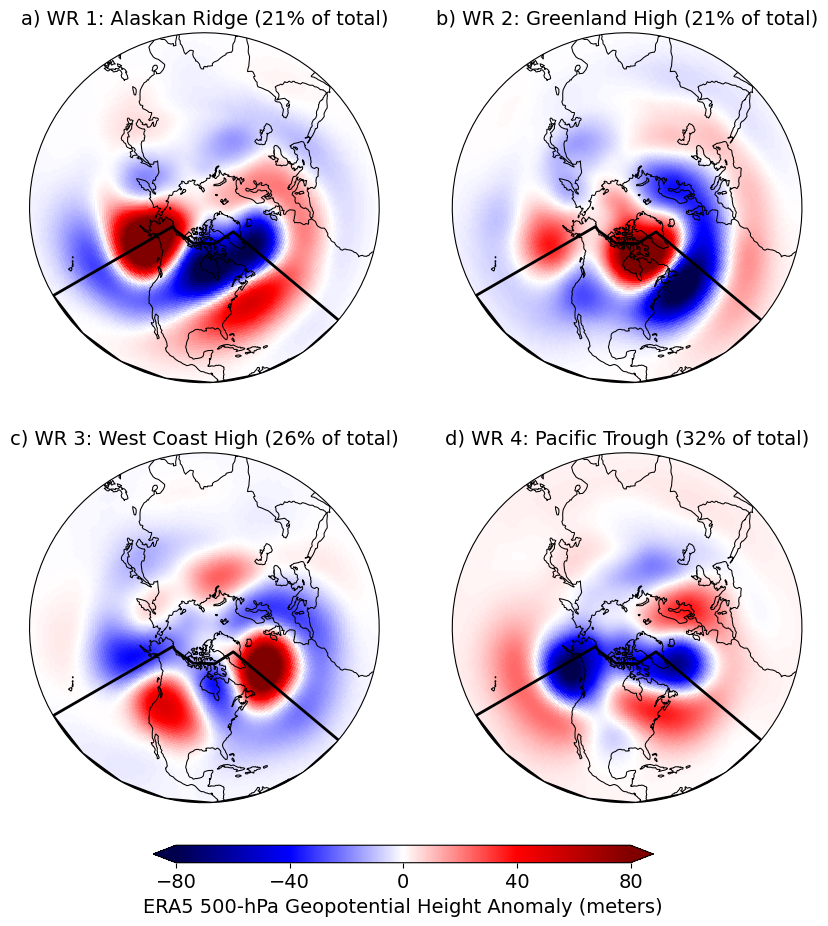

In [32]:
lons, lats = np.meshgrid(ds_era5_afterPCA.lon, ds_era5_afterPCA.lat)

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90+360)),
    figsize=(10, 10))

# ---

axs[0][0].pcolormesh(ds_era_anomalies.lon, ds_era_anomalies.lat, mean_wr_0,
                     transform=ccrs.PlateCarree(),
                     vmin=-80, vmax=80, cmap='seismic')

axs[0][0].set_title(
    f'a) WR 1: Alaskan Ridge ({int(np.around((p0) * 100))}% of total)', 
    fontsize=14)

axs[0][0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[0][0].margins(x=0, y=0)

axs[0][0].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[0][0].set_boundary(circle, transform=axs[0][0].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[0][0].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

axs[0][1].pcolormesh(ds_era_anomalies.lon, ds_era_anomalies.lat, mean_wr_1,
                     transform=ccrs.PlateCarree(), 
                     vmin=-80, vmax=80, cmap='seismic')

axs[0][1].set_title(
    f'b) WR 2: Greenland High ({int(np.around((p1) * 100))}% of total)', 
    fontsize=14)

axs[0][1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[0][1].margins(x=0, y=0)

axs[0][1].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[0][1].set_boundary(circle, transform=axs[0][1].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[0][1].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

axs[1][0].pcolormesh(ds_era_anomalies.lon, ds_era_anomalies.lat, mean_wr_2,
                     transform=ccrs.PlateCarree(),
                     vmin=-80, vmax=80, cmap='seismic')

axs[1][0].set_title(
    f'c) WR 3: West Coast High ({int(np.around((p2) * 100))}% of total)', 
    fontsize=14)

axs[1][0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[1][0].margins(x=0, y=0)

axs[1][0].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[1][0].set_boundary(circle, transform=axs[1][0].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[1][0].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

pm = axs[1][1].pcolormesh(ds_era_anomalies.lon, ds_era_anomalies.lat, mean_wr_3,
                          transform=ccrs.PlateCarree(),
                          vmin=-80, vmax=80, cmap='seismic')

axs[1][1].set_title(
    f'd) WR 4: Pacific Trough ({int(np.around((p3) * 100))}% of total)',
    fontsize=14)

axs[1][1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[1][1].margins(x=0,y=0)

axs[1][1].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[1][1].set_boundary(circle, transform=axs[1][1].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[1][1].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.0175])

ticks_1 = [-80, -40, 0, 40, 80]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

# plt.tight_layout()
plt.savefig("../../Figures/WR_ERA5_v3.png", bbox_inches='tight', dpi=500)
plt.show()

# ---
